# Casino HMM: learning (parameter estimation)

This notebook continues the "occasionally dishonest casino" example from the preceding notebook.
There, we assumed we knew the parameters of the model: the probability of switching between fair and loaded dice and the probabilities of the different outcomes (1,...,6) for each die. 

Here, our goal is **learn these parameters from data**.  We will sample data from the model as before, but now we will estimate the parameters using eith stochastic gradient descent (SGD) or expectation-maximization (EM).

The figure below shows the _graphical model_, complete with the parameter nodes.
<p align="center">
  <img src="https://github.com/probml/dynamax/blob/main/docs/figures/hmmDgmPlatesY.png?raw=true">
</p>
The filled in nodes are those which are observed (i.e. the emissions), and the unfilled nodes are ones that must be inferred (i.e. the latent states and parameters).  

In Dynamax, the [`CategoricalHMM`](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.CategoricalHMM) assumes conjugate, Dirichlet prior distributions on the model parameters. Let $K$ denote the number of discrete states ($K=2$ in the casino example, either fair or loaded), and let $C$ the number of categories the emissions can assume ($C=6$ in the casino example, the number of faces of each die). The priors are:
\begin{align*}
\pi &\sim \mathrm{Dir}(\alpha 1_K) \\
A_k &\sim \mathrm{Dir}(\beta 1_K) \quad \text{for } k=1,\ldots, K \\
B_k &\sim \mathrm{Dir}(\gamma 1_C) \quad \text{for } k=1,\ldots, K
\end{align*}
Thus, the full prior distribution is,
\begin{align*}
p(\theta) &= \mathrm{Dir}(\pi \mid \alpha 1_K) \prod_{k=1}^K \mathrm{Dir}(A_k \mid \beta 1_K) \, \mathrm{Dir}(B_k \mid \gamma 1_C)
\end{align*}
The hyperparameters can be specified in the [`CategoricalHMM`](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.CategoricalHMM) constructor..

The **learning objective** is to find parameters tham maximize the marginal probability,
\begin{align*}
\theta^\star &= \text{arg max}_{\theta} \; p(\theta \mid y_{1:T}) \\
&= \text{arg max}_{\theta} \; p(\theta, y_{1:T})
\end{align*}
This is called the _maximum a posteriori_ (MAP) estimate. Dynamax supports two algorithms for MAP estimation: expectation-maximization (EM) and stochastic gradient descent (SGD), which are described below.

## Setup

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from jax import vmap

from dynamax.hidden_markov_model import CategoricalHMM

## Sample data from true model

First we construct an HMM and sample data from it, just as in the preceding notebook.

In [3]:
num_states = 2      # two types of dice (fair and loaded)
num_emissions = 1   # only one die is rolled at a time
num_classes = 6     # each die has six faces

initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.95, 0.05], 
                               [0.10, 0.90]])
emission_probs = jnp.array([[1/6,  1/6,  1/6,  1/6,  1/6,  1/6],    # fair die
                            [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]])  # loaded die


# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
params, _ = hmm.initialize(initial_probs=initial_probs,
                           transition_matrix=transition_matrix,
                           emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes))

In [4]:
num_batches = 5
num_timesteps = 5000
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

batch_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(42), num_batches))

print(f"batch_states.shape:    {batch_states.shape}") 
print(f"batch_emissions.shape: {batch_emissions.shape}") 

batch_states.shape: (5, 5000)
batch_emissions.shape: (5, 5000, 1)


We'll write a simple function to print the parameters in a more digestible format.

In [5]:
def print_params(params):
    jnp.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    print("initial probs:")
    print(params.initial.probs)
    print("transition matrix:")
    print(params.transitions.transition_matrix)
    print("emission probs:")
    print(params.emissions.probs[:, 0, :]) # since num_emissions = 1
    
print_params(params)

initial probs:
[0.500 0.500]
transition matrix:
[[0.950 0.050]
 [0.100 0.900]]
emission probs:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.100 0.100 0.100 0.100 0.100 0.500]]


## Learning with Gradient Descent

Perhaps the simplest learning algorithm is to directly maximize the marginal probability with gradient ascent. Since optimization algorithms are typically formulated as _minimization_ algorithms, we will instead use gradient _descent_ to solve the equivalent problem of _minimizing the negative log marginal probability_, $-\log p(y_{1:T}, \theta)$. On each iteration, we compute the objective, take its gradient, and update our parameters by taking a step in the direction of steepest descent. 

```{note}
Even though JAX code looks just like regular numpy code, it supports automatic differentiation, making gradient descent straightforward to implement.
```

The first step is to randomly initialize new parameters. You can do that by calling `hmm.initialize(key)`,
where `key` is a JAX pseudorandom number generator (PRNG) key. When no other keyword arguments are supplied, this function will return parameters randomly sampled from the prior.

In [14]:
key = jr.PRNGKey(3)
fbgd_params, fbgd_props = hmm.initialize(key)

print("Randomly initialized parameters")
print_params(fbgd_params)

Randomly initialized parameters
initial probs:
[0.653 0.347]
transition matrix:
[[0.383 0.617]
 [0.172 0.828]]
emission probs:
[[0.176 0.211 0.269 0.106 0.074 0.164]
 [0.155 0.175 0.093 0.057 0.078 0.442]]


```{note}
Notice that `initialize` returns two things, the parameters and their properties. Among other things, the properties allow you to specify which parameters should be learned. You can set the `trainable` flag to False if you want to fix certain parmeters.
```

### Gradient descent is a special case of _stochastic_ gradient descent

Gradient descent is a special case of stochastic gradient descent (SGD) in which each iteration uses all the data to compute the descent direction for parameter updates. In contrast, SGD uses only a _minibatch_ of data in each update. You can think of gradient descent as the special case where the minibatch is really the entire dataset. That's why we sometimes call it _full batch_ gradient descent. When you're working with very large datasets (e.g. datasets with many sequences), however, minibatches can be very informative, and SGD can converge more quickly than full batch gradient descent. 

Dynamax models have a `fit_sgd` function that runs SGD. If you want to run full batch gradient descent, all you have to do set `batch_size=num_batches`, as below.

In [7]:
fbgd_key, key = jr.split(key)
fbgd_params, fbgd_losses = hmm.fit_sgd(fbgd_params, 
                                       fbgd_props, 
                                       batch_emissions, 
                                       optimizer=optax.sgd(learning_rate=1e-2, momentum=0.95),
                                       batch_size=num_batches, 
                                       num_epochs=400, 
                                       key=fbgd_key)

### Stochastic Gradient Descent with Mini-Batches

Now let's run it with stochastic gradient descent using a batch size of two sequences per mini-batch. 

In [8]:
key = jr.PRNGKey(3)
sgd_params, sgd_param_props = hmm.initialize(key)
sgd_key, key = jr.split(key)
sgd_params, sgd_losses = hmm.fit_sgd(sgd_params, 
                                     sgd_param_props, 
                                     batch_emissions, 
                                     optimizer=optax.sgd(learning_rate=1e-2, momentum=0.95),
                                     batch_size=2, 
                                     num_epochs=400, 
                                     key=sgd_key)

Text(0.5, 1.0, 'Full Batch Gradient Descent Learning Curve')

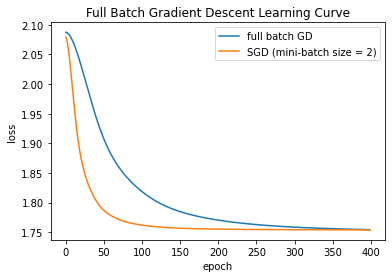

In [9]:
plt.plot(fbgd_losses, label="full batch GD")
plt.plot(sgd_losses, label="SGD (mini-batch size = 2)")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
_ = plt.title("Full Batch Gradient Descent Learning Curve")

As you can see, stochastic gradient descent converges much more quickly that full-batch gradient descent in this example. Intuitively, that's because SGD takes multiple steps per _epoch_ (i.e. each complete sweep through the dataset), whereas full-batch gradient descent takes only one.

The algorithms appear to have converged, but have they learned the correct parameters? Let's see...

In [10]:
# Print the paramters after learning
print("Full batch gradient descent params:")
print_params(fbgd_params)
print("")
print("Stochastic gradient descent params:")
print_params(sgd_params)

Full batch gradient descent params:
initial probs:
[0.662 0.338]
transition matrix:
[[0.938 0.062]
 [0.025 0.975]]
emission probs:
[[0.183 0.158 0.183 0.232 0.206 0.038]
 [0.144 0.147 0.140 0.133 0.134 0.302]]

Stochastic gradient descent params:
initial probs:
[0.658 0.342]
transition matrix:
[[0.905 0.095]
 [0.024 0.976]]
emission probs:
[[0.180 0.205 0.193 0.187 0.194 0.041]
 [0.145 0.139 0.129 0.131 0.135 0.321]]


Close, but not perfect!

### Expectation-Maximization

The more traditional way to estimate the parameters of an HMM is by expectation-maximization (EM). EM alternates between two steps:
- **E-step:** Inferring the posterior distribution of latent states $z_{1:T}$ given the parameters $\theta = (\pi, A, B)$. This step essentially runs the HMM forward-backward algorithm from the preceding notebook!
- **M-step:** Updating the parameters to maximize the expected log probability.
By iteratively performing these two steps, the algorithm converges to a local maximum of the marginal probability, $p(y_{1:T}, \theta)$, and hence to a MAP estimate of the parameters.

In practice, EM often converges much quicker than SGD, especially when the models are "nice" (e.g. constructed with exponential family emission distributions). That is why dynamax has closed form M-steps for a variety of HMMs.

In [11]:
key = jr.PRNGKey(3)
em_params, em_param_props = hmm.initialize(key)
em_params, log_probs = hmm.fit_em(em_params, 
                                  em_param_props, 
                                  batch_emissions, 
                                  num_iters=400)

### Compare the learning curves

Finally, let's compare the learning curve of EM to those of SGD. For comparison, we plot the loss associated with the true parameters that generated the data.

```{important}
To compare the log probabilities returned by `fit_em` to the losses returned by `fit_SGD`, you need to negate the log probabilities and divide by the total number of emissions. This is because optimization library defaults typically assume the loss is scaled to be $\mathcal{O}(1)$.
```

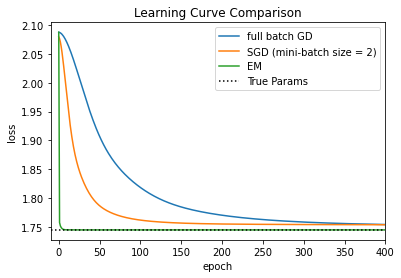

In [12]:
# Compute the "losses" from EM 
em_losses = -log_probs / batch_emissions.size 

# Compute the loss if you used the parameters that generated the data
true_loss = vmap(partial(hmm.marginal_log_prob, params))(batch_emissions).sum()
true_loss += hmm.log_prior(params)
true_loss = -true_loss / batch_emissions.size

# Plot the learning curves
plt.plot(fbgd_losses, label="full batch GD")
plt.plot(sgd_losses, label="SGD (mini-batch size = 2)")
plt.plot(em_losses, label="EM")
plt.axhline(true_loss, color='k', linestyle=':', label="True Params")
plt.legend()
plt.xlim(-10, 400)
plt.xlabel("epoch")
plt.ylabel("loss")
_ = plt.title("Learning Curve Comparison")

Not only does EM converge much faster on this example (here, in only a handful of iterations), it also converges to a better estimate of the parameters. Indeed, it essentially matches the loss obtained by the parameters that truly generated the data. We see that its parameter estimates are nearly the same as the true parameters.

In [13]:
print_params(em_params)

initial probs:
[0.373 0.627]
transition matrix:
[[0.946 0.054]
 [0.092 0.908]]
emission probs:
[[0.171 0.173 0.171 0.164 0.164 0.157]
 [0.109 0.106 0.101 0.110 0.105 0.469]]


## Conclusion

This notebook showed how to learn the parameters of an HMM using SGD (with full batch or with mini-batches) and EM. For many HMMs, especially the exponential family HMMs with exact M-steps implemented in Dynamax, EM tends to converge very quickly.

This notebook glossed over some important details:
- Both SGD and EM are prone to getting stuck in local optima. For example, if you change the key for the random initialization, you may find that the learned parameters are not as good. There are a few ways around that problem. One is to use a heuristic to initialize the parameters more intelligently. Another is to use many random initializations of the model and keep the one that achieves the best loss.
- This notebook did not address the important question of _how to determine the number of discrete states_. We often use cross-validation for that purpose, as described next.

So far, we have focused on HMMs with discrete emissions from a categorical distribution. The next notebook will illustrate a Gaussian HMM for continuous data. We will also discuss some of the concerns above.